In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings, string
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('downloads/fakereviews.txt')
df.head()

,category,rating,label,text_
0,Home_and_Restaurant_5,5.0,CG,Love this! Food quality and taste is very food
1,Home_and_Restaurant_5,4.0,CG,The selection on this menu was great so far
2,Home_and_Restaurant_5,5.0,CG,Friendly staff.good food and homely environmen...
3,Home_and_Restaurant_5,1.0,CG,Food prices are very high
4,Home_and_Restaurant_5,5.0,CG,Very nice set. Good quality. Loved this place....


In [4]:
df.head()

,category,rating,label,text_
0,Home_and_Restaurant_5,5.0,CG,Love this! Food quality and taste is very food
1,Home_and_Restaurant_5,4.0,CG,The selection on this menu was great so far
2,Home_and_Restaurant_5,5.0,CG,Friendly staff.good food and homely environmen...
3,Home_and_Restaurant_5,1.0,CG,Food prices are very high
4,Home_and_Restaurant_5,5.0,CG,Very nice set. Good quality. Loved this place....


In [5]:
df.dropna(inplace=True)

In [6]:
df['length'] = df['text_'].apply(len)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
 4   length    40432 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


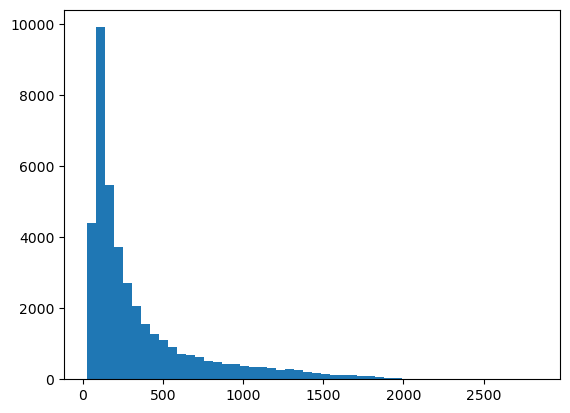

In [8]:
plt.hist(df['length'],bins=50)
plt.show()

In [9]:
df.groupby('label').describe()

rating                                                length  \
         count      mean       std  min  25%  50%  75%  max    count   
label                                                                  
CG     20216.0  4.259844  1.141055  1.0  4.0  5.0  5.0  5.0  20216.0   
OR     20216.0  4.253265  1.147652  1.0  4.0  5.0  5.0  5.0  20216.0   

                                                                  
             mean         std   min    25%    50%    75%     max  
label                                                             
CG     306.192273  307.720347  24.0   96.0  174.5  383.0  1717.0  
OR     397.916700  420.120183  28.0  121.0  224.0  499.0  2836.0

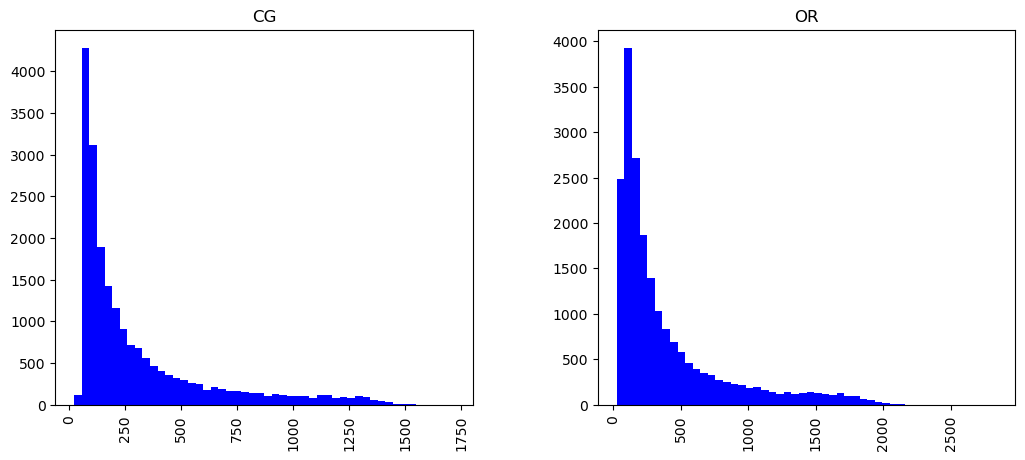

In [10]:
df.hist(column='length',by='label',bins=50,color='blue',figsize=(12,5))
plt.show()

In [11]:
df[df['label']=='OR'][['text_','length']].sort_values(by='length',ascending=False).head().iloc[0].text_

'WEAK ON CURRENT SCIENCE.\r\nAfter seeing it twice, I agree with much (but not all) of the positive five star reviews. Out of respect for those who READ reviews, I\'ll not repeat everything that I like about the presentation. I found the goofy oversize earrings, hairdo, and facial hair arrangement of Daniel Vitalis, (described as a "Wild Food Expert") distracting. UGH. Ditto for David Wolfe, who had an extremely goofy wild hairdo. On the other hand, Jon Gabriel, described as an "author and weight loss expert" was nicely groomed and a good presenter. His story of personal transformation of a fellow of over 400 pounds (whew) to becoming a jock of normal weight was inspiring. Christiane Northrup preserves her rank as one of America\'s cutest doctors. A really nice looking woman! Presentations by Dr. Mercola, Jason Vale, Kris Carr, Alejandro Junger were fine. It was disappointing to have Jamie Oliver (so popular in the UK) give Baby Cow Growth Fluid a pass with unscientific but popular ide

In [17]:
df.length.describe()

count    40432.000000
mean       352.054487
std        371.074698
min         24.000000
25%        107.000000
50%        198.000000
75%        440.000000
max       2836.000000
Name: length, dtype: float64

In [14]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [15]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x0000024582FD4AF0>)

In [16]:
import nltk

In [22]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vshiv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:",len(bow_transformer.vocabulary_))

Total Vocabulary: 61618


In [23]:
review4 = df['text_'][3]
review4

'Food prices are very high'

In [24]:
bow_msg4 = bow_transformer.transform([review4])
print(bow_msg4)
print(bow_msg4.shape)

  (0, 9744)	1
  (0, 39484)	1
  (0, 49221)	1
(1, 61618)


In [25]:
print(bow_transformer.get_feature_names()[15841])
print(bow_transformer.get_feature_names()[23848])

NOWHERE
Warrick


In [27]:
bow_reviews = bow_transformer.transform(df['text_'])

In [28]:
print("Shape of Bag of Words Transformer for the entire reviews corpus:",bow_reviews.shape)
print("Amount of non zero values in the bag of words model:",bow_reviews.nnz)

Shape of Bag of Words Transformer for the entire reviews corpus: (40432, 61618)
Amount of non zero values in the bag of words model: 1071770


In [29]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.04


In [30]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_rev4 = tfidf_transformer.transform(bow_msg4)
print(bow_msg4)

  (0, 9744)	1
  (0, 39484)	1
  (0, 49221)	1


In [31]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

10.914254381647021
2.9117275133827123


In [32]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40432, 61618)
No. of Dimensions: 2


In [33]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.35)

# LOGISTIC REGRESSION

In [34]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])

In [35]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000024582FD4AF0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', LogisticRegression())])

In [36]:
lr_pred = pipeline.predict(review_test)
lr_pred

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'CG'], dtype=object)

In [37]:
print('Classification Report:',classification_report(label_test,lr_pred))
print('Confusion Matrix:',confusion_matrix(label_test,lr_pred))
print('Accuracy Score:',accuracy_score(label_test,lr_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.90      0.86      0.88      7064
          OR       0.86      0.90      0.88      7088

    accuracy                           0.88     14152
   macro avg       0.88      0.88      0.88     14152
weighted avg       0.88      0.88      0.88     14152

Confusion Matrix: [[6050 1014]
 [ 699 6389]]
Accuracy Score: 0.8789570378745054
Model Prediction Accuracy: 87.9%


# MULTINOMIAL NAIVE BAYES

In [38]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])


In [39]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000024582FD4AF0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [40]:
predictions = pipeline.predict(review_test)
predictions

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'CG'], dtype='<U2')

In [41]:
print('Classification Report:',classification_report(label_test,predictions))
print('Confusion Matrix:',confusion_matrix(label_test,predictions))
print('Accuracy Score:',accuracy_score(label_test,predictions))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.83      0.92      0.87      7064
          OR       0.91      0.81      0.85      7088

    accuracy                           0.86     14152
   macro avg       0.87      0.86      0.86     14152
weighted avg       0.87      0.86      0.86     14152

Confusion Matrix: [[6471  593]
 [1370 5718]]
Accuracy Score: 0.8612916902204636
Model Prediction Accuracy: 86.13%


# SUPPORT VECTOR MACHINE

In [42]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SVC())
])

In [43]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000024582FD4AF0>)),
                ('tfidf', TfidfTransformer()), ('classifier', SVC())])

In [44]:
svc_pred = pipeline.predict(review_test)
svc_pred

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'CG'], dtype=object)

In [45]:
print('Classification Report:',classification_report(label_test,svc_pred))
print('Confusion Matrix:',confusion_matrix(label_test,svc_pred))
print('Accuracy Score:',accuracy_score(label_test,svc_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')

Classification Report:               precision    recall  f1-score   support

          CG       0.92      0.86      0.89      7064
          OR       0.87      0.92      0.90      7088

    accuracy                           0.89     14152
   macro avg       0.89      0.89      0.89     14152
weighted avg       0.89      0.89      0.89     14152

Confusion Matrix: [[6101  963]
 [ 562 6526]]
Accuracy Score: 0.8922413793103449
Model Prediction Accuracy: 89.22%


# STOCHASTIC GRADIENT DESCENT

In [46]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',SGDClassifier())
])

In [47]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x0000024582FD4AF0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', SGDClassifier())])

In [48]:
SGD_pred = pipeline.predict(review_test)
SGD_pred

array(['OR', 'OR', 'CG', ..., 'CG', 'CG', 'CG'], dtype='<U2')

In [49]:
print('Classification Report:',classification_report(label_test,SGD_pred))
print('Confusion Matrix:',confusion_matrix(label_test,SGD_pred))
print('Accuracy Score:',accuracy_score(label_test,SGD_pred))
print('Model Prediction Accuracy:',str(np.round(accuracy_score(label_test,SGD_pred)*100,2)) + '%')


Classification Report:               precision    recall  f1-score   support

          CG       0.91      0.85      0.88      7064
          OR       0.86      0.91      0.89      7088

    accuracy                           0.88     14152
   macro avg       0.88      0.88      0.88     14152
weighted avg       0.88      0.88      0.88     14152

Confusion Matrix: [[6022 1042]
 [ 625 6463]]
Accuracy Score: 0.882207461842849
Model Prediction Accuracy: 88.22%


# .4 Algorithms Accuracy

In [50]:
print('Performance of various ML models:')
print('\n')
print('Logistic Regression Prediction Accuracy:',str(np.round(accuracy_score(label_test,lr_pred)*100,2)) + '%')
print('Multinomial Naive Bayes Prediction Accuracy:',str(np.round(accuracy_score(label_test,predictions)*100,2)) + '%')
print('Support Vector Machines Prediction Accuracy:',str(np.round(accuracy_score(label_test,svc_pred)*100,2)) + '%')
print('Stochastic Gradient Descent Prediction Accuracy:',str(np.round(accuracy_score(label_test,SGD_pred)*100,2)) + '%')

Performance of various ML models:


Logistic Regression Prediction Accuracy: 87.9%
Multinomial Naive Bayes Prediction Accuracy: 86.13%
Support Vector Machines Prediction Accuracy: 89.22%
Stochastic Gradient Descent Prediction Accuracy: 88.22%
